In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
import multivariatet as mt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

## read in data

In [5]:
mnist = pd.read_csv('../datasets/mnist/train.csv')
# mnist = pd.read_csv('../datasets/fashion/fashion-mnist_test.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [6]:
# voice = pd.read_csv('../datasets/voice/voice.csv')
# full_X = voice[voice.columns[:-1]].values
# full_y = voice.label.values

# full_y = np.asarray(list(map(lambda x: 0 if x=='male' else 1, full_y)))

# X = full_X
# y = full_y

# n,d = X.shape

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

## kernel generation functions

In [7]:
def generate_kernel(m=40, q=10, s=1/d, scale=True):
    q_arr = np.random.uniform(low=0.5, high=4, size=q) # multipliers for size of domain of inner uniform distribution

    if scale:
        s = s/np.var(X_train)
    std = np.sqrt(2*s)
    W = np.random.uniform(low=-std*q_arr, high=std*q_arr, size=(m,d,q))
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m,1))
    
    def ker(x, y):
        z1 = np.cos(np.dot(x, W) + b)
        z2 = np.cos(np.dot(y, W) + b)
        res = np.tensordot(z1, z2, axes=([1,2],[1,2])) / (m*q)
        return res
    
    return ker

    x: test, d
    y: train, d
    W: q, m, d ---- m, d, q
    b: 1, m
    z1: test, m ---- test, m, q
    z2: train, m ---- train, m, q
    res: test, train

## experiments

### deterministic

In [49]:
gamma_val = 'scale'

In [53]:
det_svm = SVC(gamma=gamma_val)
det_svm.fit(X_train, y_train)
det_score = det_svm.score(X_test, y_test)

In [54]:
iterations = 40
det_times = np.empty((iterations))

for i in trange(iterations):
    start = perf_counter()
    det_svm = SVC(gamma=gamma_val)
    det_svm.fit(X_test, y_test)
    _ = det_svm.score(X_test, y_test)
    det_times[i] = perf_counter() - start

100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


In [55]:
print(f'Accuracy: {det_score}, time: {np.mean(times)}')

Accuracy: 0.905, time: 4.128664026000015


### randomized

In [39]:
iterations = 50
scores = np.empty((iterations))
times = np.empty((iterations))
    

for i in trange(iterations):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(X_train, y_train)
    scores[i] = random_svm.score(X_test, y_test)
    times[i]= perf_counter() - start

stat = np.empty(7)
stat[0] = np.min(scores)
stat[1] = np.quantile(scores, 0.25)
stat[2] = np.median(scores)
stat[3] = np.quantile(scores, 0.75)
stat[4] = np.max(scores)
stat[5] = np.mean(scores)
stat[6] = np.std(scores)

100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


In [40]:
print(f'Mean accuracy: {stat[5]}, stdev: {stat[6]}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {stat[0]}, Q1: {stat[1]}, Q2: {stat[2]}, Q3: {stat[3]}, Q4: {stat[4]}')

Mean accuracy: 0.8206, stdev: 0.024609754163745702, mean time: 4.128664026000015
Acc. stats: Q0: 0.75, Q1: 0.81, Q2: 0.8225, Q3: 0.835, Q4: 0.87


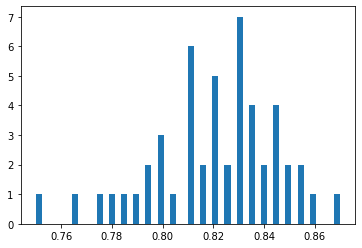

In [41]:
plt.hist(scores, bins=50);

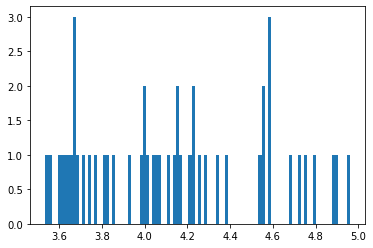

In [42]:
plt.hist(times, bins=100);

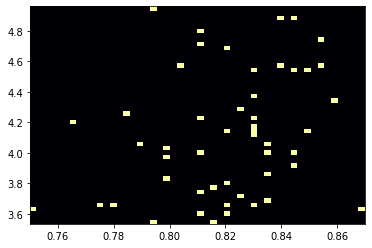

In [58]:
plt.hist2d(scores, times, bins=50, cmap='inferno');

### cheating randomized (training on the test data)

The purpose of this experiment is to see whether the model is able to recover all of the modes that it learns on.

In [44]:
iterations = 50
cscores = np.empty((iterations))
ctimes = np.empty((iterations))
    

for i in trange(iterations):
    start = perf_counter()
    crandom_svm = SVC(kernel=generate_kernel())
    crandom_svm.fit(X_test, y_test) # caution: do not blindly copy this code.
                                   # training on the test data is generally frowned upon.
    cscores[i] = crandom_svm.score(X_test, y_test)
    ctimes[i]= perf_counter() - start

cstat = np.empty(7)
cstat[0] = np.min(cscores)
cstat[1] = np.quantile(cscores, 0.25)
cstat[2] = np.median(cscores)
cstat[3] = np.quantile(cscores, 0.75)
cstat[4] = np.max(cscores)
cstat[5] = np.mean(cscores)
cstat[6] = np.std(cscores)

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [45]:
print(f'Mean accuracy: {cstat[5]}, stdev: {cstat[6]}, mean time: {np.mean(ctimes)}')
print(f'Acc. stats: Q0: {cstat[0]}, Q1: {cstat[1]}, Q2: {cstat[2]}, Q3: {cstat[3]}, Q4: {cstat[4]}')

Mean accuracy: 0.8241999999999998, stdev: 0.04868634305428987, mean time: 1.091704465999992
Acc. stats: Q0: 0.67, Q1: 0.805, Q2: 0.83, Q3: 0.86, Q4: 0.905


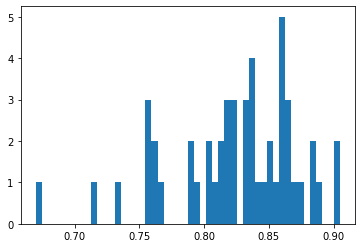

In [46]:
plt.hist(cscores, bins=50);

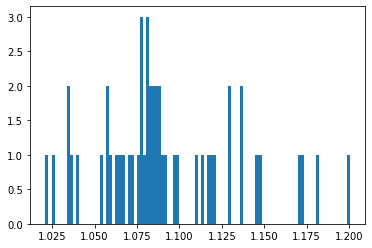

In [47]:
plt.hist(ctimes, bins=100);

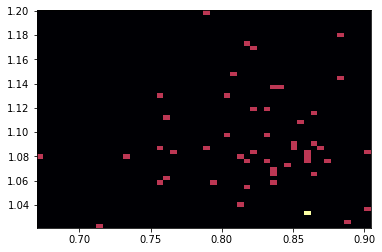

In [59]:
plt.hist2d(cscores, ctimes, bins=50, cmap='inferno');